# I. The Bernstein-Vazirani problem
## Exercise I.1:
Implement and run on (noisless and noisy fake backend) __Bernstein-Vazirani alghoritm__ \
https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/quantum-query-algorithms#the-bernstein-vazirani-problem \
for a hidden bitstring corresponding to a binary representation of a first letter of your last name.

# II. The Simon problem
## Exercise II.1:
Implement and run on (noisless and noisy fake backend) __Simon alghoritm__ following tutorial:\
https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/quantum-query-algorithms#simons-algorithm \
for a hidden bitstring corresponding to a binary representation of a first letter of your last name.

https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/simon.ipynb

# III. Quantum Phase estimation (QPE)
## Exercise III.1:

Implement quantum phase estimation algorithm (for ideal and noisy quantum simulator) for arbitrary searched phase $\theta$ following tutorial:

https://learning.quantum.ibm.com/course/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation
https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring#general-procedure-and-analysis

1. First consider phases for which $2^n \cdot \theta$ is an integer number (e.g. $\theta=1/8, \theta=3/8, \theta=5/8$), where n is the number of qubits in the counting register.

2. Next, consider phases for which $2^n \cdot \theta$ is not an integer (e.g. $\theta=1/3, \theta=1/5, \theta=1/7$). Show that the acuurancy of estimating phase $\theta$ improves with increasing number of qubits  in the counting register.

https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-phase-estimation.ipynb

In [1]:
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorSampler
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke, FakeKyiv

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_qsphere, plot_distribution, plot_state_city
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, SamplerV2 as Sampler
from qiskit.providers.basic_provider import BasicProvider
from qiskit.circuit.library import UGate
backend = BasicProvider().get_backend('basic_simulator')
import numpy as np
from numpy import sqrt, pi, random
import matplotlib.pyplot as plt
import galois

# The Bernstein-Vazirani problem

In [2]:
def run_circuit(qc):
  # Run on sim

  simulator = AerSimulator()
  shots = 1024

  # Transpile and run
  qc_transpiled = transpile(qc, simulator)
  job = simulator.run(qc_transpiled, shots=shots)
  result = job.result()
  counts = result.get_counts()
  print(counts)
  plot_histogram(counts, title='Simulation')

  # Run on fake

  backend = FakeSherbrooke()

  # Transpile first
  qc_real = transpile(qc, backend, optimization_level=3)
  display(qc_real.draw('mpl'))

  job = backend.run(qc_real, shots=1024)
  counts_r = job.result().get_counts()
  display(plot_histogram(counts_r, title="FakeSherbrooke"))
  display(plot_distribution(counts_r, title="FakeSherbrooke"))

01000101


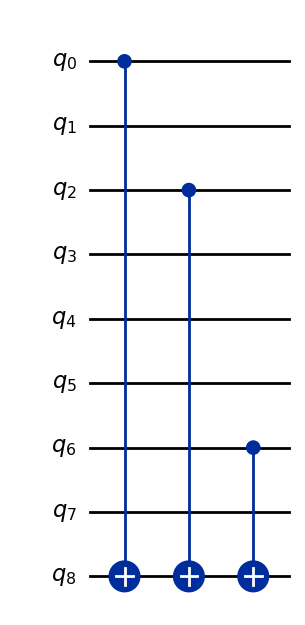

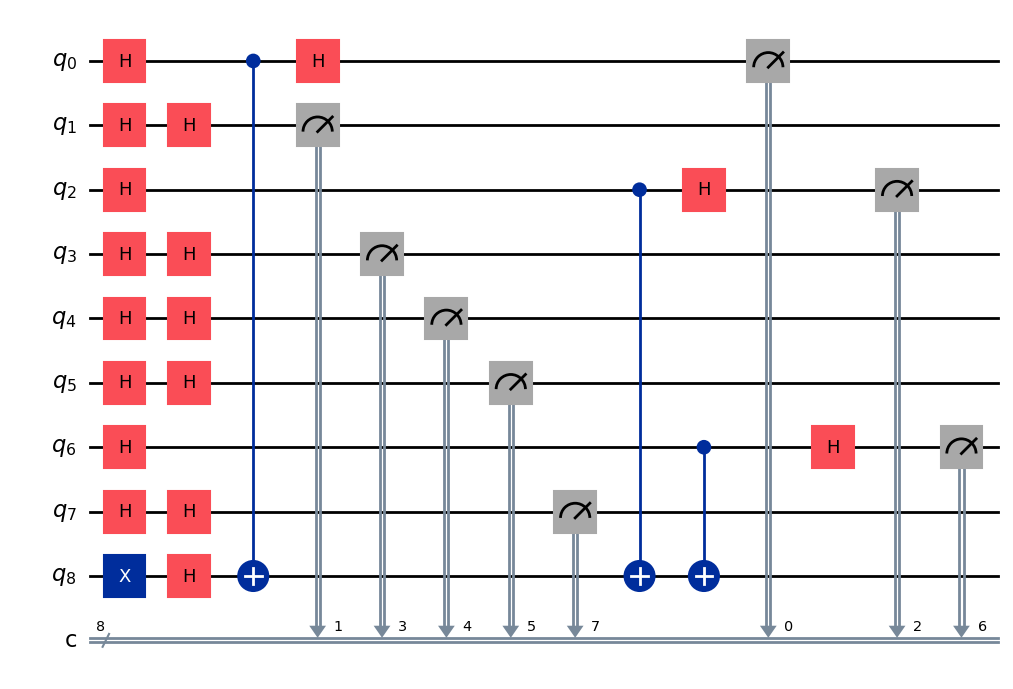

{'01000101': 1024}


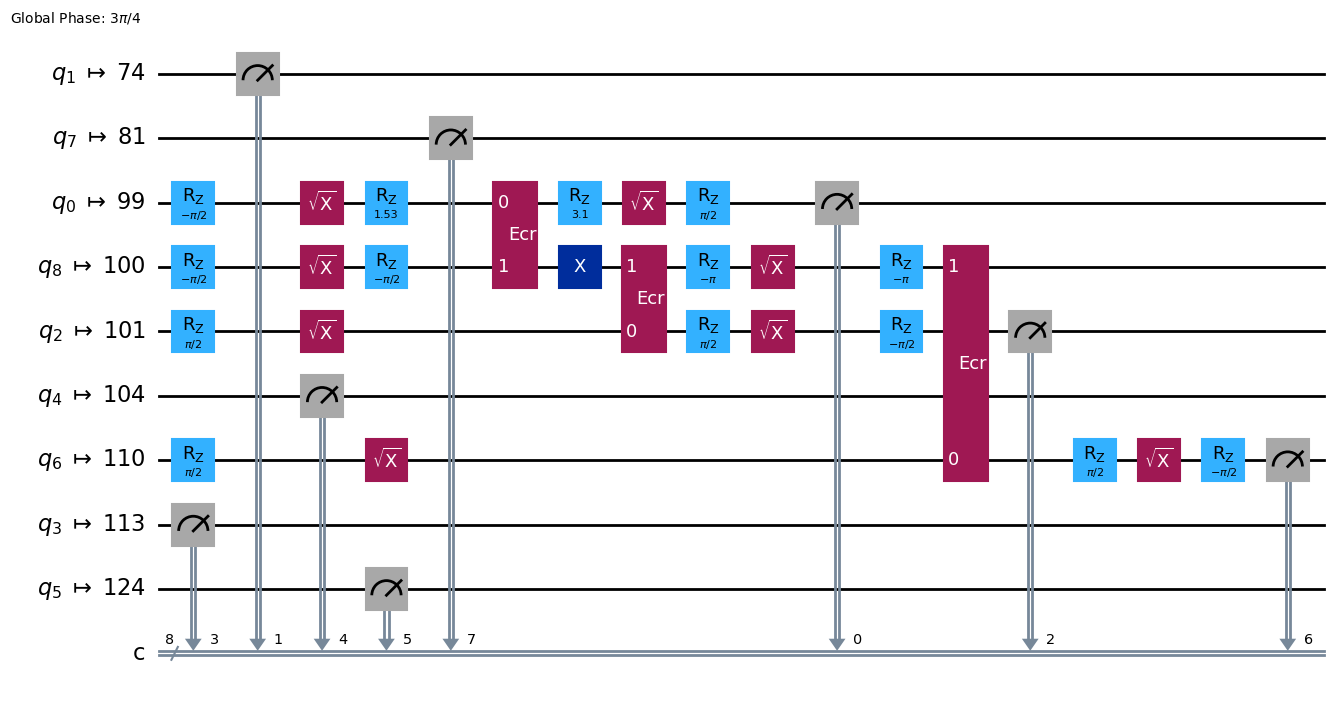

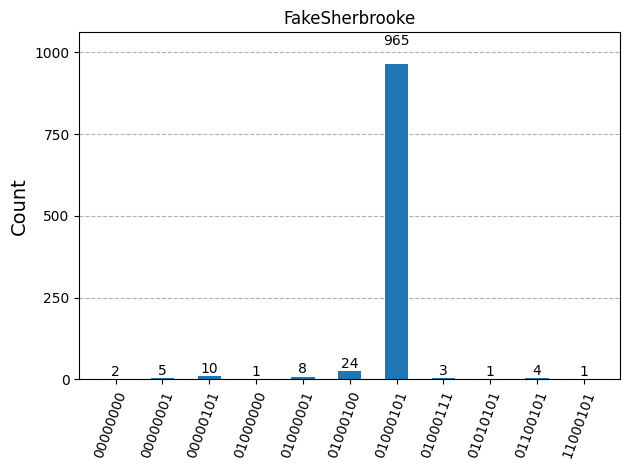

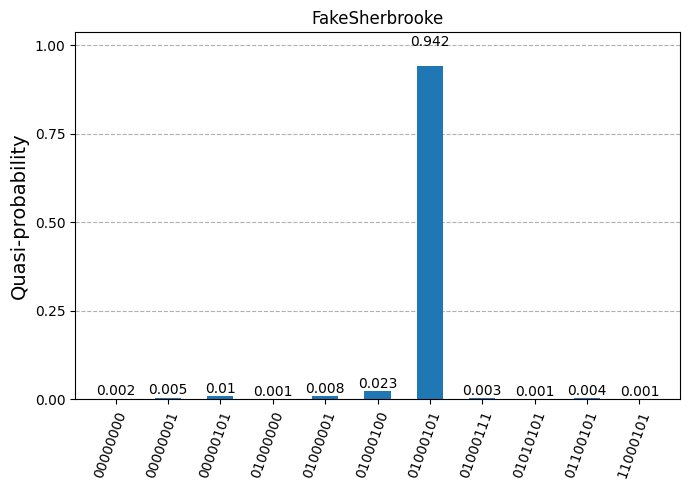

In [3]:
letter = format(ord("E"), "08b")
print(letter)

def bv_query(s: str):
    qc = QuantumCircuit(len(s) + 1)
    for index, bit in enumerate(reversed(s)):
        if bit == "1":
            qc.cx(index, len(s))
    return qc

def compile_circuit(function: QuantumCircuit):
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)
    qc.h(range(n + 1))
    qc.compose(function, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))
    return qc

query = bv_query(letter)
display(query.draw(output="mpl"))

qc = compile_circuit(query)
display(qc.draw(output='mpl'))

run_circuit(qc)


# The Simon problem

Running noiseless...


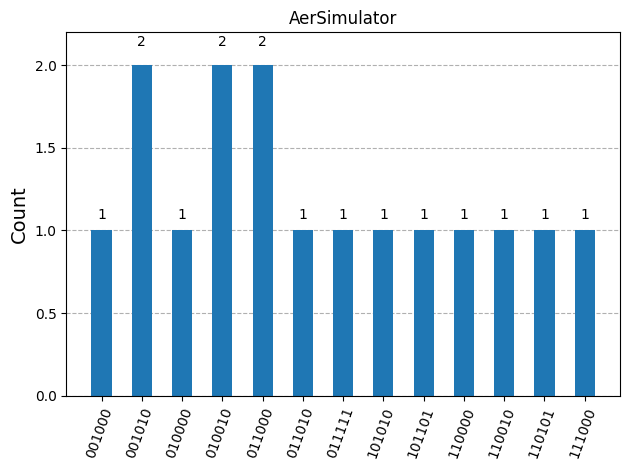

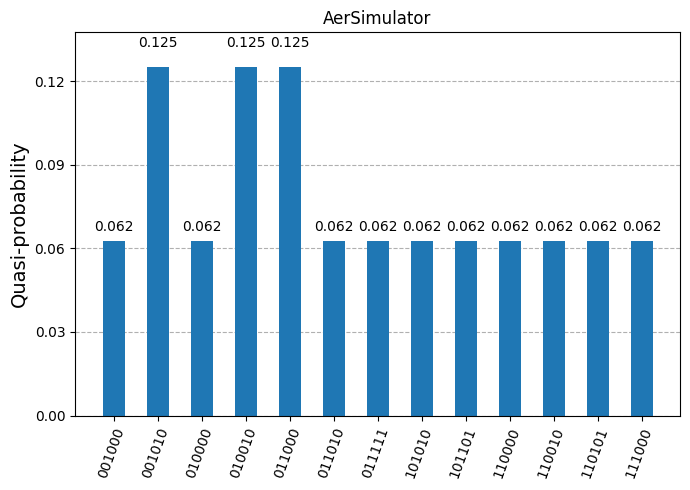

1
Guess for hidden string s: 000101
Correct: 000101
Running noisy...


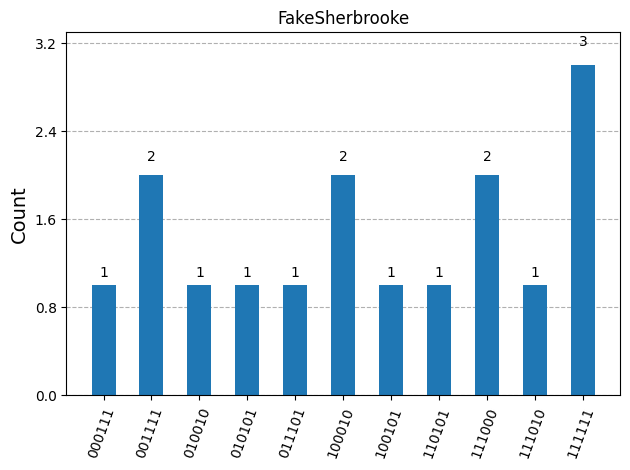

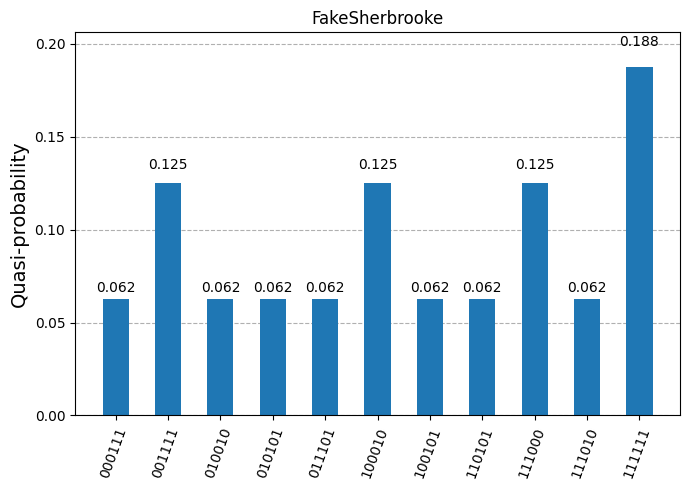

1
Guess for hidden string s: 000101
Correct: 000101


In [14]:
def simon_function(s: str):
    n = len(s)
    qc = QuantumCircuit(2 * n)
    pi = np.random.permutation(2**n)

    query_gate = np.zeros((4**n, 4**n))
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]
            query_gate[x + 2**n * z, x + 2**n * y] = 1

    qc.unitary(query_gate, range(2 * n))
    return qc

def simon_measurements_noiseless(problem: QuantumCircuit, k: int):
    n = problem.num_qubits // 2

    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))
    qc.compose(problem, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))

    result = AerSimulator().run(qc, shots=k, memory=True).result()

    counts = result.get_counts()
    display(plot_histogram(counts, title="AerSimulator"))
    display(plot_distribution(counts, title="AerSimulator"))
    return result.get_memory()

def simon_measurements_noisy(problem: QuantumCircuit, k: int):
    n = problem.num_qubits // 2

    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))
    qc.compose(problem, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))

    result = FakeSherbrooke().run(qc, shots=k, memory=True).result()

    counts_r = result.get_counts()
    display(plot_histogram(counts_r, title="FakeSherbrooke"))
    display(plot_distribution(counts_r, title="FakeSherbrooke"))
    return result.get_memory()

# display(simon_measurements_noiseless(simon_function("10011"),k=12))

def simon_algorithm(problem: QuantumCircuit, noisy=False):
    if noisy:
        measurements = simon_measurements_noisy(problem, k=problem.num_qubits // 2 + 10)
    else:
        measurements = simon_measurements_noiseless(problem, k=problem.num_qubits // 2 + 10)

    matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)

    null_space = galois.GF(2)(matrix).null_space()

    print(len(null_space))
    print(f"Guess for hidden string s: {"0" * len(measurements[0]) if len(null_space) == 0 else "".join(np.array(null_space[0]).astype(str))}")
    # if len(null_space) == 0:
    #     # No non-trivial solution; `s` is all-zeros
    #     return "0" * len(measurements[0])
    # return "".join(np.array(null_space[0]).astype(str))

print("Running noiseless...")
simon_algorithm(simon_function(letter[2:]), noisy=False)
print(f"Correct: {letter[2:]}")

print("Running noisy...")
simon_algorithm(simon_function(letter[2:]), noisy=True)
print(f"Correct: {letter[2:]}")

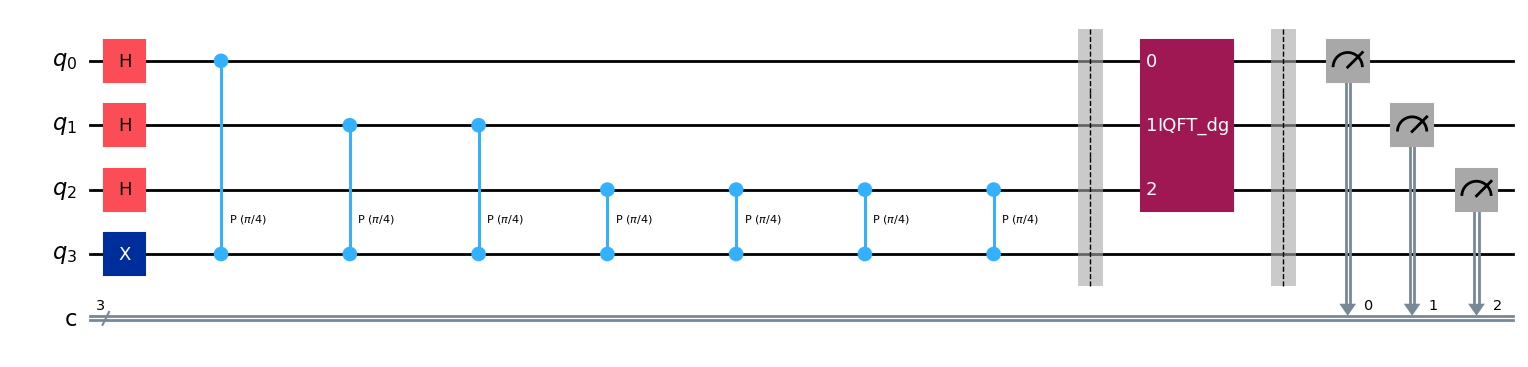

In [21]:
from qiskit.circuit.library import QFT

qpe = QuantumCircuit(4, 3)
qpe.x(3)
for qubit in range(3):
    qpe.h(qubit)

angle = 1/8
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(2*np.pi*angle, counting_qubit, 3); # controlled-T
    repetitions *= 2

qpe.barrier()
qpe = qpe.compose(QFT(3, inverse=True), [0,1,2])
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)

qpe.draw(output='mpl')


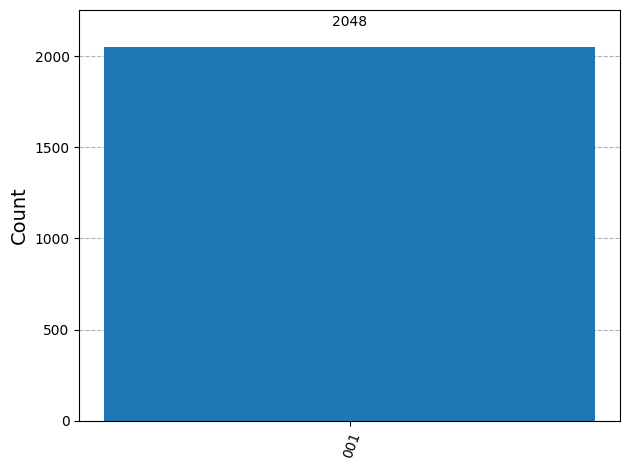

In [22]:
t_qpe = transpile(qpe, AerSimulator())
results = AerSimulator().run(t_qpe, shots=2048).result()
answer = results.get_counts()

plot_histogram(answer)

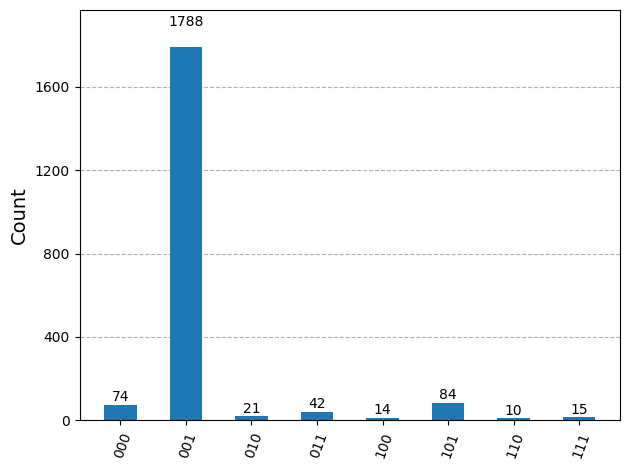

In [23]:
t_qpe = transpile(qpe, FakeSherbrooke())
results = FakeSherbrooke().run(t_qpe, shots=2048).result()
answer = results.get_counts()

plot_histogram(answer)

In [ ]:
from fractions import Fraction

print(f"expected: {Fraction(1, 8)} (001/2**len(word))")

expected: 1/8 (001/2**len(word))


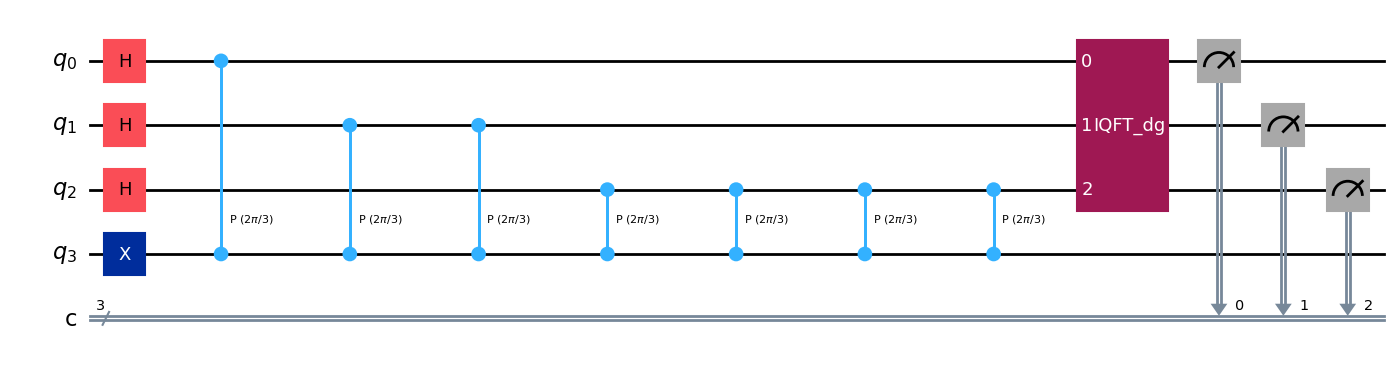

In [27]:
qpe2 = QuantumCircuit(4, 3)

for qubit in range(3):
    qpe2.h(qubit)
qpe2.x(3)

angle = 1/3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe2.cp(2*np.pi*angle, counting_qubit, 3);
    repetitions *= 2

# Do the inverse QFT:
qpe2 = qpe2.compose(QFT(3, inverse=True), [0,1,2])

for n in range(3):
    qpe2.measure(n,n)

qpe2.draw(output='mpl')

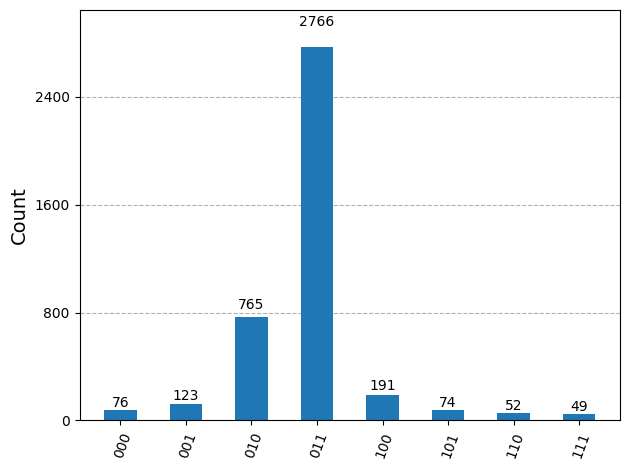

In [28]:
aer_sim = AerSimulator()
shots = 4096
t_qpe2 = transpile(qpe2, aer_sim)
results = aer_sim.run(t_qpe2, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

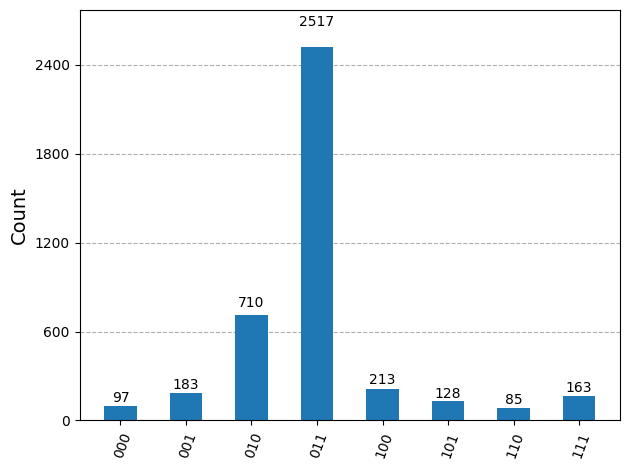

In [26]:
sim = FakeSherbrooke()
shots = 4096
t_qpe2 = transpile(qpe2, sim)
results = sim.run(t_qpe2, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

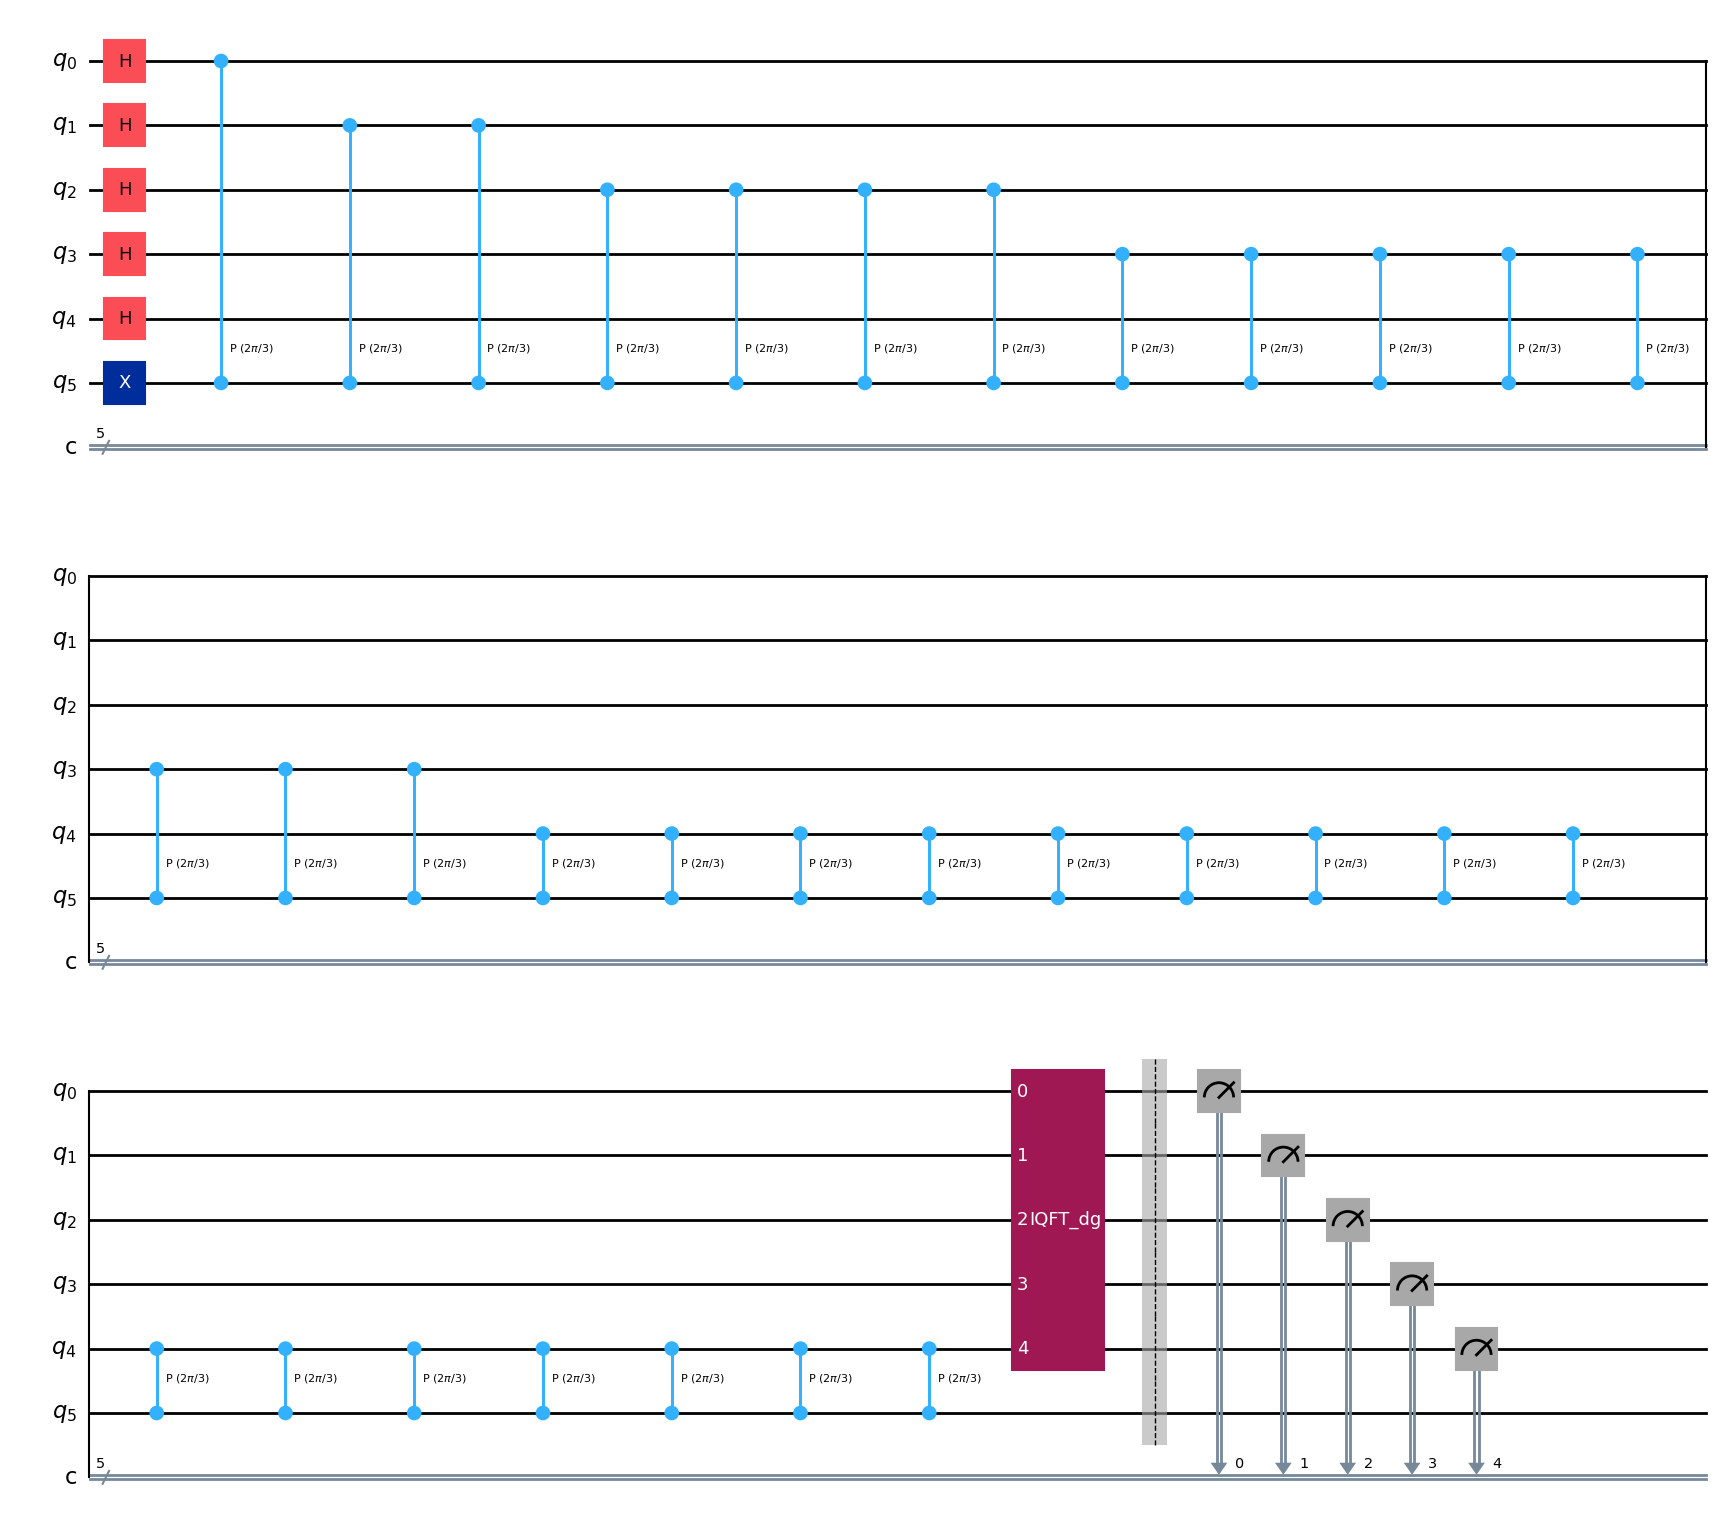

In [29]:
qpe3 = QuantumCircuit(6, 5)

for qubit in range(5):
    qpe3.h(qubit)

qpe3.x(5)

angle = 1/3
repetitions = 1
for counting_qubit in range(5):
    for i in range(repetitions):
        qpe3.cp(2*np.pi*angle, counting_qubit, 5);
    repetitions *= 2

qpe3 = qpe3.compose(QFT(5, inverse=True), range(5))

qpe3.barrier()
for n in range(5):
    qpe3.measure(n,n)

qpe3.draw(output='mpl')

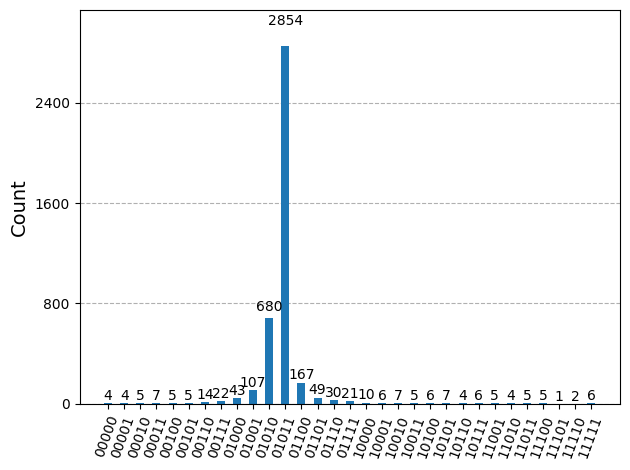

In [31]:
aer_sim = AerSimulator()
shots = 4096
t_qpe3 = transpile(qpe3, aer_sim)
results = aer_sim.run(t_qpe3, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)



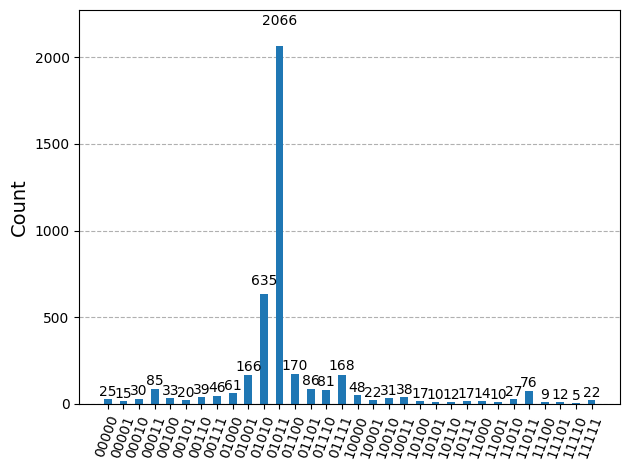

In [32]:
sim = FakeSherbrooke()
shots = 4096
t_qpe3 = transpile(qpe3, sim)
results = sim.run(t_qpe3, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)